# Country Clustering using K-Means and Classification using Random Forest and SVM

### COLUMNS DESCRIPTION
`country` - Name of the country\
`child_mort` - Death of children under 5 years of age per 1000 live births\
`exports` - Exports of goods and services per capita. Given as %age of the GDP per capita\
`health` - Total health spending per capita. Given as %age of GDP per capita \
`imports` - Imports of goods and services per capita. Given as %age of the GDP per capita\
`Income` - Net income per person\
`Inflation` - The measurement of the annual growth rate of the Total GDP\
`life_expec` - The average number of years a new born child would live if the current mortality patterns are to remain the same\
`total_fer` - The number of children that would be born to each woman if the current age-fertility rates remain the same\
`gdpp` - The GDP per capita. Calculated as the Total GDP divided by the total population.

Source : https://www.kaggle.com/rohan0301/unsupervised-learning-on-country-data

### Pre-Processing Data

**Import library and dataset**

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, PowerTransformer, PolynomialFeatures, OneHotEncoder, StandardScaler, normalize
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import dython
from dython.nominal import associations, cramers_v, correlation_ratio, theils_u
import dateparser
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_columns = 999

#unsupervised
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.mixture import GaussianMixture

In [2]:
df = pd.read_csv(r'C:\Users\Administrator\OneDrive\data science\purwadhika\job connector\kumpulan latihan\modul 3\dataset\Country-data.csv')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.20,10.00,7.58,44.90,1610,9.44,56.20,5.82,553
1,Albania,16.60,28.00,6.55,48.60,9930,4.49,76.30,1.65,4090
2,Algeria,27.30,38.40,4.17,31.40,12900,16.10,76.50,2.89,4460
3,Angola,119.00,62.30,2.85,42.90,5900,22.40,60.10,6.16,3530
4,Antigua and Barbuda,10.30,45.50,6.03,58.90,19100,1.44,76.80,2.13,12200


In [3]:
df.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [4]:
df.shape

(167, 10)

In [5]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00
mean,38.27,41.11,6.82,46.89,17144.69,7.78,70.56,2.95,12964.16
std,40.33,27.41,2.75,24.21,19278.07,10.57,8.89,1.51,18328.70
min,2.60,0.11,1.81,0.07,609.00,-4.21,32.10,1.15,231.00
25%,8.25,23.80,4.92,30.20,3355.00,1.81,65.30,1.79,1330.00
50%,19.30,35.00,6.32,43.30,9960.00,5.39,73.10,2.41,4660.00
75%,62.10,51.35,8.60,58.75,22800.00,10.75,76.80,3.88,14050.00
max,208.00,200.00,17.90,174.00,125000.00,104.00,82.80,7.49,105000.00


**Note** : there are many outliers (look at the max value) but we can't drop them because they may contain important information, so we treat the outliers as extreme values.

# Data Cleaning

In [3]:
## Checking Data

In [9]:
countryDesc = []

for i in df.columns:
    countryDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        (((df[i].isna().sum()) / len(df)) * 100).round(2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

In [10]:
pd.DataFrame(data = countryDesc, columns= [
    'Data Feature',
    'Data Types',
    'Null',
    'Null Pct',
    'Unique',
    'Unique Sample'
] )

,Data Feature,Data Types,Null,Null Pct,Unique,Unique Sample
0,country,object,0,0.00,167,"[Macedonia, FYR, Barbados]"
1,child_mort,float64,0,0.00,139,"[123.0, 19.1]"
2,exports,float64,0,0.00,147,"[23.5, 29.1]"
3,health,float64,0,0.00,147,"[6.03, 3.4]"
4,imports,float64,0,0.00,151,"[41.2, 36.6]"
5,income,int64,0,0.00,156,"[9960, 12000]"
6,inflation,float64,0,0.00,156,"[0.16, -4.21]"
7,life_expec,float64,0,0.00,127,"[75.8, 82.8]"
8,total_fer,float64,0,0.00,138,"[1.25, 5.27]"
9,gdpp,int64,0,0.00,157,"[16000, 12600]"


**Note :** No missing value in this dataset

**Note :** Country Name has data types object, so we can drop it for the modelling

In [11]:
df_segment = df.drop('country', axis=1)
df_segment

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.20,10.00,7.58,44.90,1610,9.44,56.20,5.82,553
1,16.60,28.00,6.55,48.60,9930,4.49,76.30,1.65,4090
2,27.30,38.40,4.17,31.40,12900,16.10,76.50,2.89,4460
3,119.00,62.30,2.85,42.90,5900,22.40,60.10,6.16,3530
4,10.30,45.50,6.03,58.90,19100,1.44,76.80,2.13,12200
...,...,...,...,...,...,...,...,...,...
162,29.20,46.60,5.25,52.70,2950,2.62,63.00,3.50,2970
163,17.10,28.50,4.91,17.60,16500,45.90,75.40,2.47,13500
164,23.30,72.00,6.84,80.20,4490,12.10,73.10,1.95,1310
165,56.30,30.00,5.18,34.40,4480,23.60,67.50,4.67,1310


### Data Normalization

In [12]:
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(df_segment) 

In [13]:
# Normalizing the Data 
normalized_df = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 

### Dimension Reduction using PCA

We apply Principal Component Analysis (PCA) to transform data to 2 dimensions for visualization because we won't be able to visualize the data in 9 dimensions. PCA transforms a large set of variables into a smaller one that still contains most of the information in the large set. Reducing the number of variables of a data.

In [16]:
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
X_principal.head(2)

,P1,P2
0,0.93,-0.05
1,-0.43,-0.14


### Clustering

#### Choosing the K

**SSE**

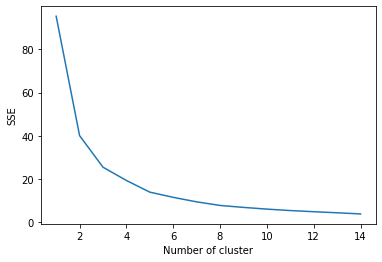

In [17]:
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_principal)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

It's hard to find the elbow point of the curve, so we use **silhouette score**.

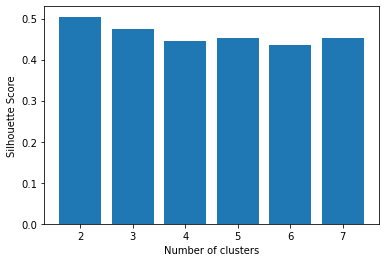

In [18]:
silhouette_scores = []

for n_cluster in range(2, 8):
    silhouette_scores.append( 
        silhouette_score(X_principal, KMeans(n_clusters = n_cluster).fit_predict(X_principal))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6, 7] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

**Note :** Highest silhouette score is **k = 2**.

In [19]:
kmean= KMeans(2)
kmean.fit(scaled_df)
labels=kmean.labels_

In [20]:
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
clusters.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.20,10.00,7.58,44.90,1610,9.44,56.20,5.82,553,1
1,Albania,16.60,28.00,6.55,48.60,9930,4.49,76.30,1.65,4090,0
2,Algeria,27.30,38.40,4.17,31.40,12900,16.10,76.50,2.89,4460,0
3,Angola,119.00,62.30,2.85,42.90,5900,22.40,60.10,6.16,3530,1
4,Antigua and Barbuda,10.30,45.50,6.03,58.90,19100,1.44,76.80,2.13,12200,0


**Interpretation of Cluster**

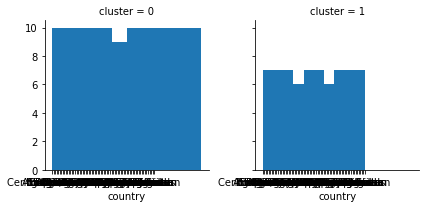

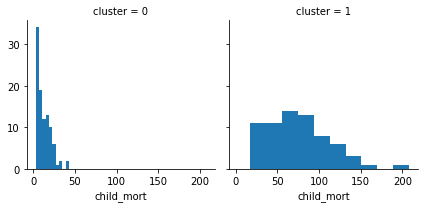

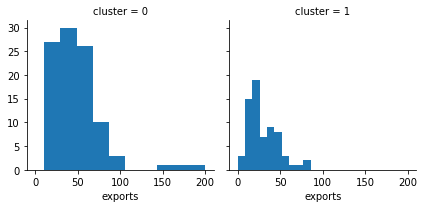

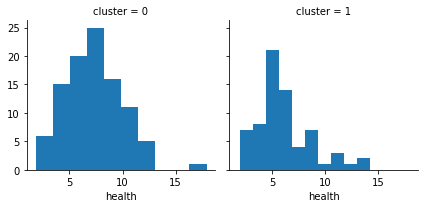

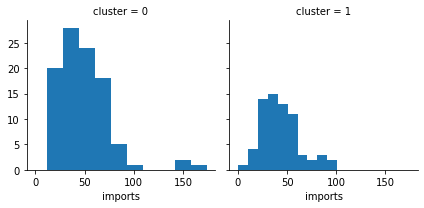

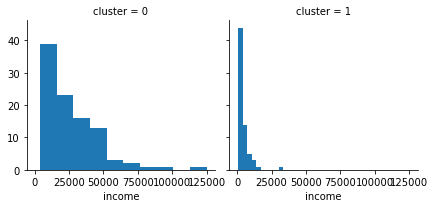

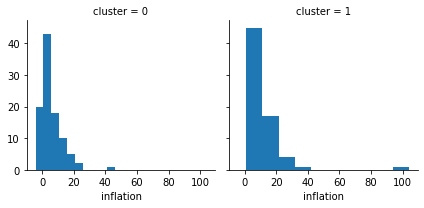

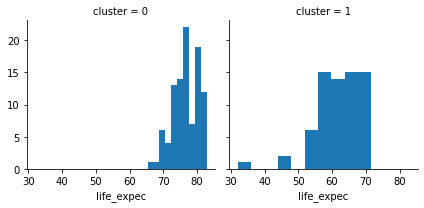

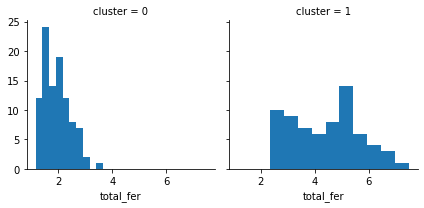

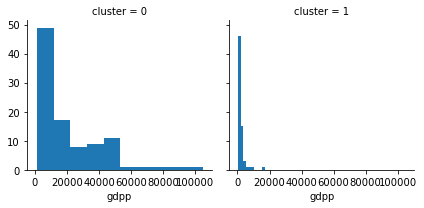

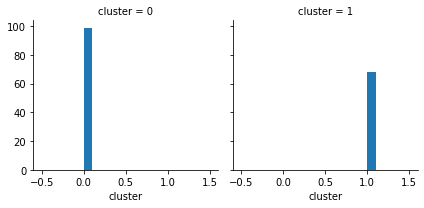

In [21]:
for c in clusters:
    grid= sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)

In [22]:
clusters['cluster'].value_counts()

0    99
1    68
Name: cluster, dtype: int64

In [23]:
clusters.groupby('cluster').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster,,,,,,,,,
0,12.16,48.60,7.31,49.12,26017.17,5.50,76.49,1.94,20507.98
1,76.28,30.20,6.09,43.64,4227.40,11.10,61.91,4.41,1981.24


### Cluster Interpretation

**Cluster 0**

**Cluster 1**

### Visualization

In [24]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(normalized_df)
principalDf = pd.DataFrame(data = principalComponents, columns=['principal component 1', 'principal component 2'])
principalDf.head(2)

,principal component 1,principal component 2
0,0.93,-0.05
1,-0.43,-0.14


In [25]:
finalDf = pd.concat([principalDf, pd.DataFrame({'cluster':labels})], axis = 1)
finalDf.head()

,principal component 1,principal component 2,cluster
0,0.93,-0.05,1
1,-0.43,-0.14,0
2,0.13,-0.37,0
3,0.88,0.19,1
4,-0.73,0.33,0


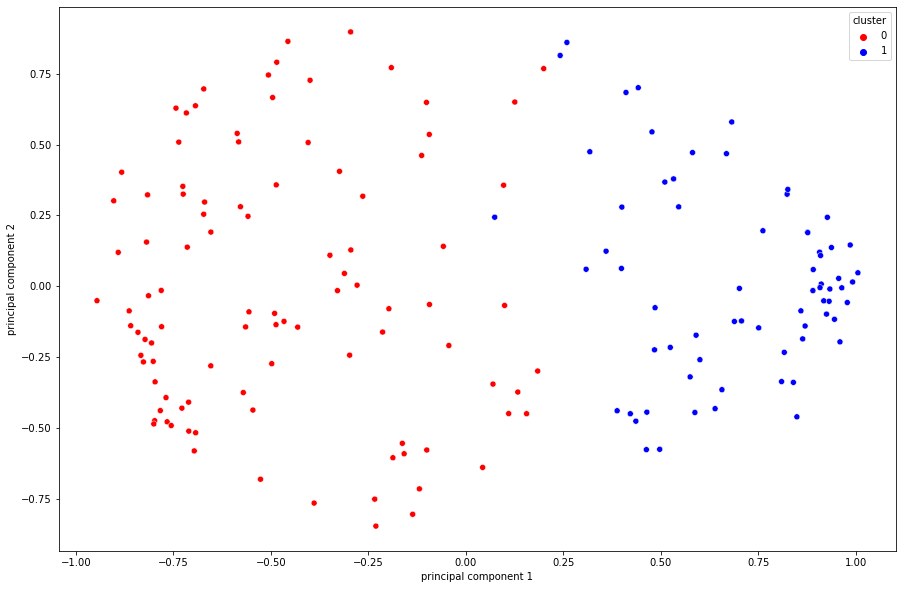

In [26]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x="principal component 1", y="principal component 2", hue="cluster", data=finalDf,palette=['red','blue'])
plt.show()

# Conclusion

all countries relatively has similar numbers based on the features. although, features that has strong impact in the segmentation are child_mort, life_expec and total_fer

* **Cluster 0 :** This country group indicates a large group of countries who have low number of death of children, high life expectation, and low number of children that would be born to each woman

* **Cluster 1 :** This country group indicates a small group of countries who have medium-high number of death of children, low-medium life expectation, and medium-high number of children that would be born to each woman

# Predict Country Segmentation

In [27]:
## Splitting data
X = clusters.drop(columns=['country', 'cluster'])
y = clusters['cluster']

In [28]:
X_train, X_test, y_train,y_test = train_test_split(X,y,stratify=y, test_size= .20, random_state=420)

In [82]:
# num_columns = ['enrollee_id','city_development_index', 'training_hours']
num_columns = ['child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])


preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns)
])


pipe_RF = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier())
])

pipe_SVM = Pipeline([
    ("prep", preprocessor),
    ("algo", SVC(probability=True))
])

## Random Forest

In [30]:
pipe_RF.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['child_mort', 'exports',
                                                   'health', 'imports',
                                                   'income', 'inflation',
                                                   'life_expec', 'total_fer',
                                                   'gdpp'])])),
                ('algo', RandomForestClassifier())])

In [31]:
y_pred_RF_ts = pipe_RF.predict(X_test)

In [32]:
print(classification_report(y_test, y_pred_RF_ts))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.93      1.00      0.97        14

    accuracy                           0.97        34
   macro avg       0.97      0.97      0.97        34
weighted avg       0.97      0.97      0.97        34



### Random Forest Hypertuning Parameter

In [33]:
pipe_RF.get_params()

{'memory': None,
 'steps': [('prep', ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('scaler', StandardScaler())]),
                                    ['child_mort', 'exports', 'health', 'imports',
                                     'income', 'inflation', 'life_expec',
                                     'total_fer', 'gdpp'])])),
  ('algo', RandomForestClassifier())],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('numeric',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', StandardScaler())]),
                                  ['child_mort', 'exports', 'health', 'imports',
                                   'income', 'inflation', 'life_expec',
                                   'total_fer', 'gdpp'])]),
 'algo': RandomForestClassifier(),
 'prep__n_jo

In [34]:
param_RF = {
    'algo__n_estimators' : np.arange(100,701,200),
    'algo__max_depth' : [None, 5,7,10],
    'algo__min_samples_leaf' : np.arange(1,26,5),
    'algo__min_samples_split' : np.arange(1,26,5)*2
}

In [35]:
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle = True, )

In [36]:
RF_RS= RandomizedSearchCV(pipe_RF, param_RF, cv=skf, n_iter=50, n_jobs=-1, verbose=1, random_state=42, scoring='accuracy')

In [37]:
RF_RS.fit(X_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   19.5s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['child_mort',
                                                                                'exports',
                                                                                'health',
                                                       

In [38]:
RF_RS.best_params_

{'algo__n_estimators': 100,
 'algo__min_samples_split': 12,
 'algo__min_samples_leaf': 1,
 'algo__max_depth': 5}

In [39]:
RF_Tuned_RS = RF_RS.best_estimator_

In [40]:
y_ts_RF1 = RF_Tuned_RS.predict(X_test)

In [41]:
print(classification_report(y_test, y_ts_RF1))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.93      1.00      0.97        14

    accuracy                           0.97        34
   macro avg       0.97      0.97      0.97        34
weighted avg       0.97      0.97      0.97        34



### Random Forest - Fine Tuning

In [42]:
param_RF2 = {
    'algo__n_estimators' : np.arange(80,160,20),
    'algo__max_depth' : [None, 2, 3, 4, 5, 6],
    'algo__min_samples_leaf' : np.arange(10,20,1),
    'algo__min_samples_split' : [1, 2, 3]
}

In [43]:
# {'algo__n_estimators': 100,
#  'algo__min_samples_split': 12,
#  'algo__min_samples_leaf': 1,
#  'algo__max_depth': 5}

In [44]:
RF_GS = GridSearchCV(pipe_RF, param_RF2, cv = skf, scoring = 'accuracy', n_jobs = -1, verbose=1)

In [45]:
RF_GS.fit(X_train,y_train)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  1.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['child_mort',
                                                                          'exports',
                                                                          'health',
                                                                          'imports',
                              

In [46]:
RF_GS.best_params_

{'algo__max_depth': 2,
 'algo__min_samples_leaf': 17,
 'algo__min_samples_split': 2,
 'algo__n_estimators': 80}

In [47]:
RF_Tuned_GS = RF_GS.best_estimator_

In [48]:
y_ts_RF2 = RF_Tuned_GS.predict(X_test)

In [49]:
print(classification_report(y_test, y_ts_RF2))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.88      1.00      0.93        14

    accuracy                           0.94        34
   macro avg       0.94      0.95      0.94        34
weighted avg       0.95      0.94      0.94        34



In [50]:
cm_RF2_Tuned = confusion_matrix(y_test, y_ts_RF2, labels=[1, 0])

In [51]:
df_RF2_Tuned = pd.DataFrame(cm_RF2_Tuned, index=['Akt 1', 'Akt 0'], columns =  ['Pred 1', 'Pred 0'])
df_RF2_Tuned

,Pred 1,Pred 0
Akt 1,14,0
Akt 0,2,18


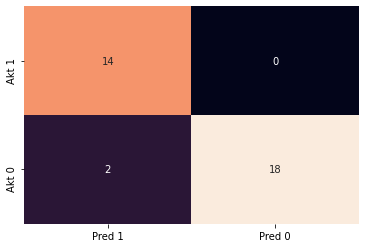

In [52]:
sns.heatmap(df_RF2_Tuned, annot=True, cbar=False)
plt.show()

### Random Forest - Fine Tuning 2

In [53]:
param_RF3 = {
    'algo__n_estimators' : np.arange(1,20,1),
    'algo__max_depth' : [None, 5, 6, 7],
    'algo__min_samples_leaf' : [3],
    'algo__min_samples_split' : [1, 2, 3]}

In [54]:
# {'algo__max_depth': 6,
#  'algo__min_samples_leaf': 4,
#  'algo__min_samples_split': 3,
#  'algo__n_estimators': 20}

In [55]:
RF_GS2 = GridSearchCV(pipe_RF, param_RF3, cv = skf, scoring = 'accuracy', n_jobs = -1, verbose=1)

In [56]:
RF_GS2.fit(X_train,y_train)

Fitting 3 folds for each of 228 candidates, totalling 684 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 684 out of 684 | elapsed:    4.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['child_mort',
                                                                          'exports',
                                                                          'health',
                                                                          'imports',
                              

In [57]:
RF_GS2.best_params_

{'algo__max_depth': None,
 'algo__min_samples_leaf': 3,
 'algo__min_samples_split': 2,
 'algo__n_estimators': 7}

In [58]:
RF_Tuned_GS2 = RF_GS2.best_estimator_

In [59]:
y_ts_RF3 = RF_Tuned_GS2.predict(X_test)

In [60]:
print(classification_report(y_test, y_ts_RF3))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.93      0.96        14

    accuracy                           0.97        34
   macro avg       0.98      0.96      0.97        34
weighted avg       0.97      0.97      0.97        34



In [83]:
y_tr_RF3 = RF_Tuned_GS2.predict(X_train)

In [84]:
print(classification_report(y_train, y_tr_RF3))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        79
           1       1.00      0.98      0.99        54

    accuracy                           0.99       133
   macro avg       0.99      0.99      0.99       133
weighted avg       0.99      0.99      0.99       133



# SVM

In [61]:
pipe_SVM.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['child_mort', 'exports',
                                                   'health', 'imports',
                                                   'income', 'inflation',
                                                   'life_expec', 'total_fer',
                                                   'gdpp'])])),
                ('algo', SVC(probability=True))])

In [62]:
y_SVM1 = pipe_SVM.predict(X_test)

In [63]:
print(classification_report(y_test, y_SVM1))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       0.92      0.86      0.89        14

    accuracy                           0.91        34
   macro avg       0.91      0.90      0.91        34
weighted avg       0.91      0.91      0.91        34



### SVM Hypertuning Parameter

In [64]:
pipe_SVM.get_params()

{'memory': None,
 'steps': [('prep', ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('scaler', StandardScaler())]),
                                    ['child_mort', 'exports', 'health', 'imports',
                                     'income', 'inflation', 'life_expec',
                                     'total_fer', 'gdpp'])])),
  ('algo', SVC(probability=True))],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('numeric',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', StandardScaler())]),
                                  ['child_mort', 'exports', 'health', 'imports',
                                   'income', 'inflation', 'life_expec',
                                   'total_fer', 'gdpp'])]),
 'algo': SVC(probability=True),
 'prep__n_jobs': N

In [65]:
param_SVM = {
    'algo__C' : np.logspace(-3 , 3, 7), #semakin tinggi, semakin kompleks. kalau overfit, kurangin nilai C
    "algo__gamma" : np.arange(10, 101, 25), #semakin tinggi, semakin kompleks. kalau overfit, kurangin nilai gamma
}

In [66]:
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle = True, )

In [67]:
SVM_RS= RandomizedSearchCV(pipe_SVM, param_SVM, cv=skf, n_iter=50, n_jobs=-1, verbose=1, random_state=42, scoring='accuracy')

In [68]:
SVM_RS.fit(X_train,y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.3s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['child_mort',
                                                                                'exports',
                                                                                'health',
                                                       

In [69]:
SVM_RS.best_params_

{'algo__gamma': 10, 'algo__C': 0.001}

In [70]:
SVM_Tuned_RS = SVM_RS.best_estimator_

In [71]:
y_ts_SVM1 = SVM_Tuned_RS.predict(X_test)

In [72]:
print(classification_report(y_test, y_ts_SVM1))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74        20
           1       0.00      0.00      0.00        14

    accuracy                           0.59        34
   macro avg       0.29      0.50      0.37        34
weighted avg       0.35      0.59      0.44        34



### SVM - Fine Tuning

In [73]:
param_SVM2 = {
    'algo__C' : np.logspace(-3 , 3, 7), #semakin tinggi, semakin kompleks. kalau overfit, kurangin nilai C
    "algo__gamma" : np.arange(10, 20, 2), #semakin tinggi, semakin kompleks. kalau overfit, kurangin nilai gamma
}

In [74]:
# {'algo__gamma': 10, 'algo__class_weight': {0: 0.1, 1: 0.9}, 'algo__C': 10.0}

In [75]:
SVM_GS = GridSearchCV(pipe_SVM, param_SVM2, cv = skf, scoring = 'accuracy', n_jobs = -1, verbose=1)

In [76]:
SVM_GS.fit(X_train, y_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  90 out of 105 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    0.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['child_mort',
                                                                          'exports',
                                                                          'health',
                                                                          'imports',
                              

In [77]:
SVM_GS.best_params_

{'algo__C': 0.001, 'algo__gamma': 10}

In [78]:
SVM_Tuned_GS = SVM_GS.best_estimator_

In [79]:
y_ts_SVM2 = SVM_Tuned_GS.predict(X_test)

In [80]:
print(classification_report(y_test, y_ts_SVM2))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74        20
           1       0.00      0.00      0.00        14

    accuracy                           0.59        34
   macro avg       0.29      0.50      0.37        34
weighted avg       0.35      0.59      0.44        34



In [85]:
y_tr_SVM2 = SVM_Tuned_GS.predict(X_train)

In [86]:
print(classification_report(y_train, y_tr_SVM2))

              precision    recall  f1-score   support

           0       0.59      1.00      0.75        79
           1       0.00      0.00      0.00        54

    accuracy                           0.59       133
   macro avg       0.30      0.50      0.37       133
weighted avg       0.35      0.59      0.44       133



# Conclusion on Data Modelling

the best model is Random Forest Classification after Fine Tuning that has accuracy score 0.99 on trainig and 0.97 on test